In [1]:
import dataset
import datetime
from datetime import timedelta
from parser import get_parser
import numpy as np 
import pandas as pd 
import torch
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt 
from utils import *
from pygData_util import *
import seaborn as sns
from utils import metrics
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from scipy.stats import pearsonr

In [2]:
sns.set_style("whitegrid")

In [3]:
data = dataset.Cdata(path='../../Custom-Semi-Supervised/data/cdata.csv')
parser = get_parser()
args = parser.parse_args(args=
                         ["--data","real-c", 
                          "--sampling","xgb",
                          "--train_from","20160101",
                          "--test_from","20190101",
                          "--test_length","365",
                          "--valid_length","90",
                          "--initial_inspection_rate", "5",
                         ])

In [4]:
# args
seed = args.seed
initial_inspection_rate = args.initial_inspection_rate
inspection_rate_option = args.inspection_plan
train_begin = args.train_from 
test_begin = args.test_from
test_length = args.test_length
valid_length = args.valid_length
chosen_data = args.data
numWeeks = args.numweeks

# Initial dataset split
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Initial dataset split
train_start_day = datetime.date(int(train_begin[:4]), int(train_begin[4:6]), int(train_begin[6:8]))
test_start_day = datetime.date(int(test_begin[:4]), int(test_begin[4:6]), int(test_begin[6:8]))
test_length = timedelta(days=test_length)    
test_end_day = test_start_day + test_length
valid_length = timedelta(days=valid_length)
valid_start_day = test_start_day - valid_length

# data
data.split(train_start_day, valid_start_day, test_start_day, test_end_day, valid_length, test_length, args)
data.featureEngineering()

Data size:
Train labeled: (59358, 40), Train unlabeled: (1127792, 40), Valid labeled: (143717, 40), Valid unlabeled: (0, 14), Test: (564355, 40)
Checking label distribution
Training: 0.011864580137056357
Validation: 0.010355445572396727
Testing: 0.012851897184822521


In [5]:
categories=["importer.id","HS6"]
gdata = GraphData(data,use_xgb=False, categories=categories)

In [6]:
# obtain DATE prediction
DATE_prediction = pd.read_csv("inductive/Cdata_5.0%_prediction.csv").values.ravel()
GNN_prediction = pd.read_csv("inductive/fullmodel_results/GNN_real-c_5.0_prediction.csv").values.ravel()
r, p_value = pearsonr(DATE_prediction,GNN_prediction)
print("Correlation:%.4f" % r)

# overall stats
print("GNN results...")
gnn_result = metrics(GNN_prediction, data.test_cls_label, data.test_reg_label,None)
print("-"*50)
print("DATE results...")
DATE_result = metrics(DATE_prediction, data.test_cls_label, data.test_reg_label,None)

Correlation:0.0720
GNN results...
Checking top 1% suspicious transactions: 5644
Precision: 0.0303, Recall: 0.0239, Revenue: 0.0369
Checking top 2% suspicious transactions: 11288
Precision: 0.0239, Recall: 0.0377, Revenue: 0.0588
Checking top 5% suspicious transactions: 28218
Precision: 0.0213, Recall: 0.0841, Revenue: 0.1092
Checking top 10% suspicious transactions: 56436
Precision: 0.0185, Recall: 0.1455, Revenue: 0.1723
--------------------------------------------------
DATE results...
Checking top 1% suspicious transactions: 5644
Precision: 0.0464, Recall: 0.0366, Revenue: 0.0558
Checking top 2% suspicious transactions: 11288
Precision: 0.0413, Recall: 0.0651, Revenue: 0.0966
Checking top 5% suspicious transactions: 28217
Precision: 0.0328, Recall: 0.1293, Revenue: 0.1867
Checking top 10% suspicious transactions: 56436
Precision: 0.0303, Recall: 0.2387, Revenue: 0.3576


### Average unseen category 
In the following cell, I calculate the ratio of unseen importer/hs in test data.<br>
* Although there are lots of new importers, they only account for a small protion.
* However, in N data, the unseen importer took a large protion in test data.

Since DATE learns **unique embeddings** for importer/hs, we should expect **DATE perform well when the unseen rate is low.**

In [7]:
print("[valid] Unseen importer rate: %.4f" % (1 - gdata.valid_user.nonzero().shape[0] / data.valid.shape[0]))
print("[Valid] Unseen HS code rate: %.4f" % (1 - gdata.valid_item.nonzero().shape[0] / data.valid.shape[0]))
print("[test] Unseen importer rate: %.4f" % (1 - gdata.test_user.nonzero().shape[0] / data.test.shape[0]))
print("[test] Unseen HS code rate: %.4f" % (1 - gdata.test_item.nonzero().shape[0] / data.test.shape[0]))

[valid] Unseen importer rate: 0.0348
[Valid] Unseen HS code rate: 0.0131
[test] Unseen importer rate: 0.0509
[test] Unseen HS code rate: 0.0474


## Prediction Analysis
Here I would like to present some analysis of predictions made by DATE and GNN model.<br>
The flow of analysis is presented as follows:
1. Overall evaluation result. (just for reference to let you know which is performing better)
2. Correlation of predictions on illicit transaction.
3. Evaluating precision/recall in different subgroups.
4. Comparing the distribution in different subgroups.

### Importer Analysis
Calculate the frequency of importers appraning in the training set.<br>
Note that interval **\[0,1)** denotes the new importer, i.e. the frequency appearing in training set is 0. <br>
* In the **top-right figure**, the majority of transactions are maed by importers that lies in subgroup [10,50).
* The **bottom-right figure** shows that the new importers have the highest illicit rate, but the # transactions of new importers is small. <br>
Therefore, having a high illicit rate might not be help for overall prediction.

===============Evaluating subgroup:[0.0, 1.0)===============
GNN Results...
Checking top 1% suspicious transactions: 288
Precision: 0.0382, Recall: 0.0132, Revenue: 0.0178
Checking top 2% suspicious transactions: 575
Precision: 0.0452, Recall: 0.0313, Revenue: 0.0426
Checking top 5% suspicious transactions: 1438
Precision: 0.0417, Recall: 0.0722, Revenue: 0.0757
Checking top 10% suspicious transactions: 2875
Precision: 0.0327, Recall: 0.1131, Revenue: 0.0944
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 288
Precision: 0.0660, Recall: 0.0229, Revenue: 0.0271
Checking top 2% suspicious transactions: 575
Precision: 0.0626, Recall: 0.0433, Revenue: 0.0569
Checking top 5% suspicious transactions: 1438
Precision: 0.0501, Recall: 0.0866, Revenue: 0.0953
Checking top 10% suspicious transactions: 2875
Precision: 0.0386, Recall: 0.1336, Revenue: 0.1413


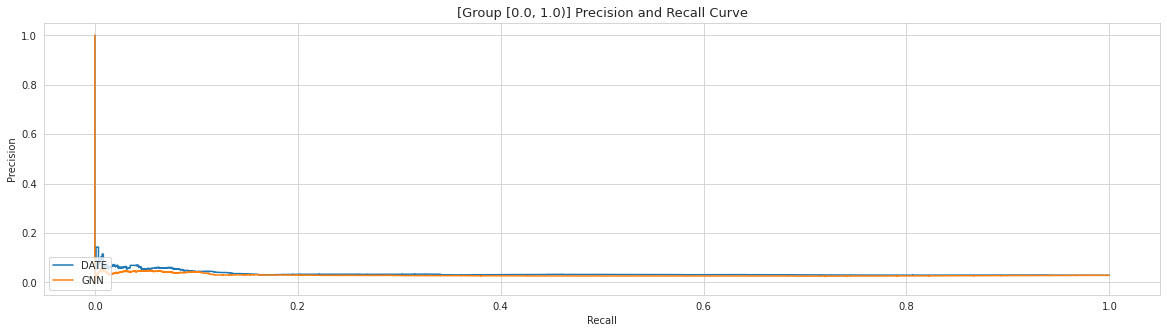

===============Evaluating subgroup:[1.0, 10.0)===============
GNN Results...
Checking top 1% suspicious transactions: 1026
Precision: 0.0468, Recall: 0.0172, Revenue: 0.0364
Checking top 2% suspicious transactions: 2052
Precision: 0.0375, Recall: 0.0275, Revenue: 0.0525
Checking top 5% suspicious transactions: 5130
Precision: 0.0345, Recall: 0.0633, Revenue: 0.0945
Checking top 10% suspicious transactions: 10260
Precision: 0.0317, Recall: 0.1162, Revenue: 0.1388
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 1026
Precision: 0.0546, Recall: 0.0200, Revenue: 0.0388
Checking top 2% suspicious transactions: 2052
Precision: 0.0463, Recall: 0.0340, Revenue: 0.0577
Checking top 5% suspicious transactions: 5130
Precision: 0.0390, Recall: 0.0715, Revenue: 0.1225
Checking top 10% suspicious transactions: 10260
Precision: 0.0386, Recall: 0.1416, Revenue: 0.2129


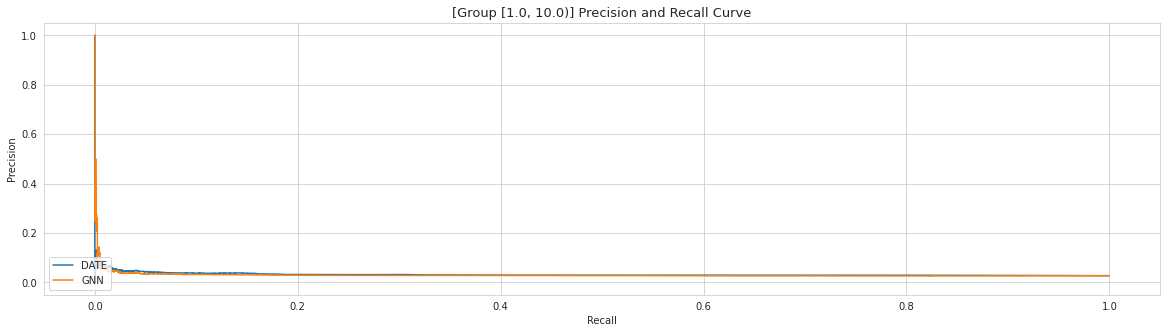

===============Evaluating subgroup:[10.0, 50.0)===============
GNN Results...
Checking top 1% suspicious transactions: 1000
Precision: 0.0390, Recall: 0.0202, Revenue: 0.0242
Checking top 2% suspicious transactions: 2000
Precision: 0.0345, Recall: 0.0358, Revenue: 0.0443
Checking top 5% suspicious transactions: 4999
Precision: 0.0320, Recall: 0.0829, Revenue: 0.0894
Checking top 10% suspicious transactions: 9998
Precision: 0.0278, Recall: 0.1440, Revenue: 0.1525
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 1000
Precision: 0.0520, Recall: 0.0269, Revenue: 0.0316
Checking top 2% suspicious transactions: 2000
Precision: 0.0445, Recall: 0.0461, Revenue: 0.0581
Checking top 5% suspicious transactions: 4999
Precision: 0.0392, Recall: 0.1016, Revenue: 0.1454
Checking top 10% suspicious transactions: 9997
Precision: 0.0338, Recall: 0.1751, Revenue: 0.2272


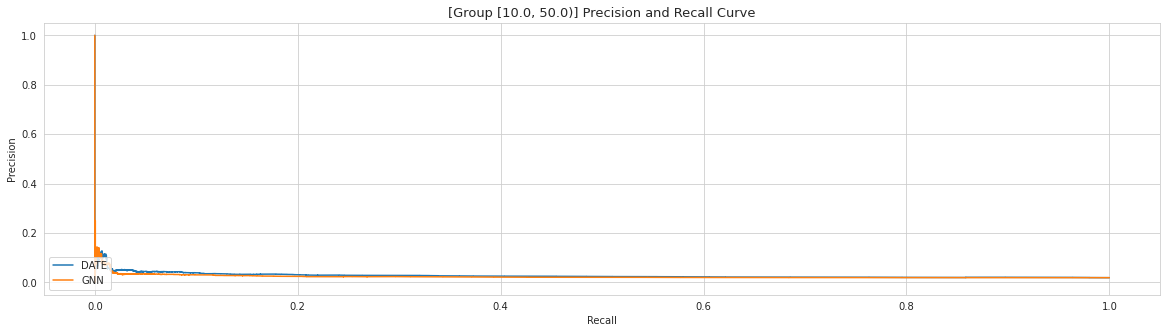

===============Evaluating subgroup:[50.0, 100.0)===============
GNN Results...
Checking top 1% suspicious transactions: 573
Precision: 0.0436, Recall: 0.0347, Revenue: 0.0604
Checking top 2% suspicious transactions: 1145
Precision: 0.0410, Recall: 0.0652, Revenue: 0.0921
Checking top 5% suspicious transactions: 2862
Precision: 0.0297, Recall: 0.1179, Revenue: 0.1787
Checking top 10% suspicious transactions: 5723
Precision: 0.0234, Recall: 0.1859, Revenue: 0.2588
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 573
Precision: 0.0349, Recall: 0.0277, Revenue: 0.0433
Checking top 2% suspicious transactions: 1145
Precision: 0.0306, Recall: 0.0485, Revenue: 0.0618
Checking top 5% suspicious transactions: 2862
Precision: 0.0238, Recall: 0.0943, Revenue: 0.1672
Checking top 10% suspicious transactions: 5723
Precision: 0.0224, Recall: 0.1775, Revenue: 0.2659


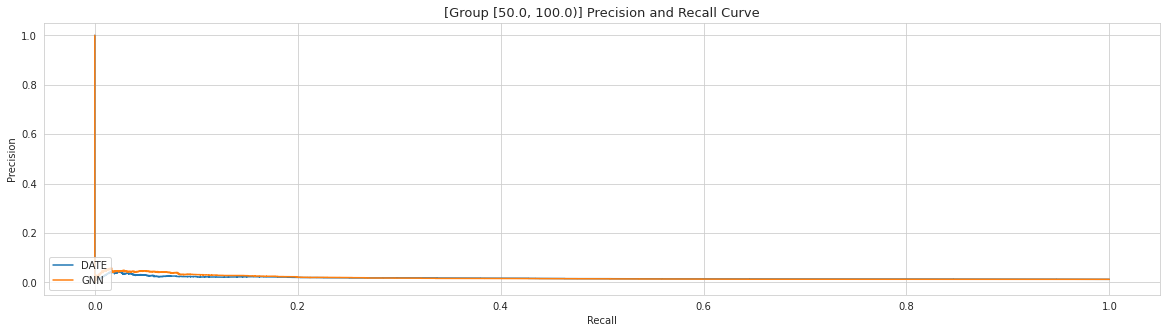

===============Evaluating subgroup:[100.0, 200.0)===============
GNN Results...
Checking top 1% suspicious transactions: 385
Precision: 0.0078, Recall: 0.0106, Revenue: 0.0618
Checking top 2% suspicious transactions: 773
Precision: 0.0065, Recall: 0.0177, Revenue: 0.1049
Checking top 5% suspicious transactions: 1933
Precision: 0.0124, Recall: 0.0851, Revenue: 0.2630
Checking top 10% suspicious transactions: 3865
Precision: 0.0098, Recall: 0.1348, Revenue: 0.2710
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 387
Precision: 0.0026, Recall: 0.0035, Revenue: 0.0000
Checking top 2% suspicious transactions: 773
Precision: 0.0026, Recall: 0.0071, Revenue: 0.0092
Checking top 5% suspicious transactions: 1933
Precision: 0.0109, Recall: 0.0745, Revenue: 0.0538
Checking top 10% suspicious transactions: 3865
Precision: 0.0106, Recall: 0.1454, Revenue: 0.2323


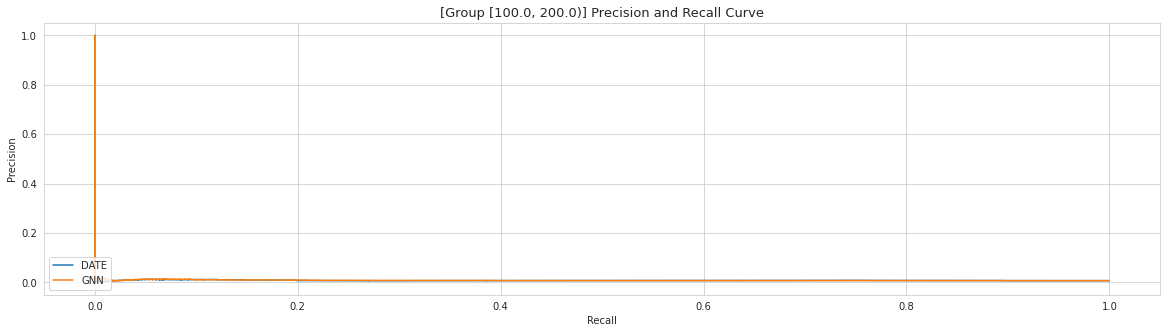

===============Evaluating subgroup:[200.0, 500.0)===============
GNN Results...
Checking top 1% suspicious transactions: 333
Precision: 0.0270, Recall: 0.0400, Revenue: 0.0311
Checking top 2% suspicious transactions: 665
Precision: 0.0150, Recall: 0.0444, Revenue: 0.0313
Checking top 5% suspicious transactions: 1662
Precision: 0.0072, Recall: 0.0533, Revenue: 0.0313
Checking top 10% suspicious transactions: 3324
Precision: 0.0081, Recall: 0.1200, Revenue: 0.0325
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 333
Precision: 0.0120, Recall: 0.0178, Revenue: 0.0068
Checking top 2% suspicious transactions: 665
Precision: 0.0090, Recall: 0.0267, Revenue: 0.0073
Checking top 5% suspicious transactions: 1662
Precision: 0.0138, Recall: 0.1022, Revenue: 0.3930
Checking top 10% suspicious transactions: 3324
Precision: 0.0196, Recall: 0.2889, Revenue: 0.8551


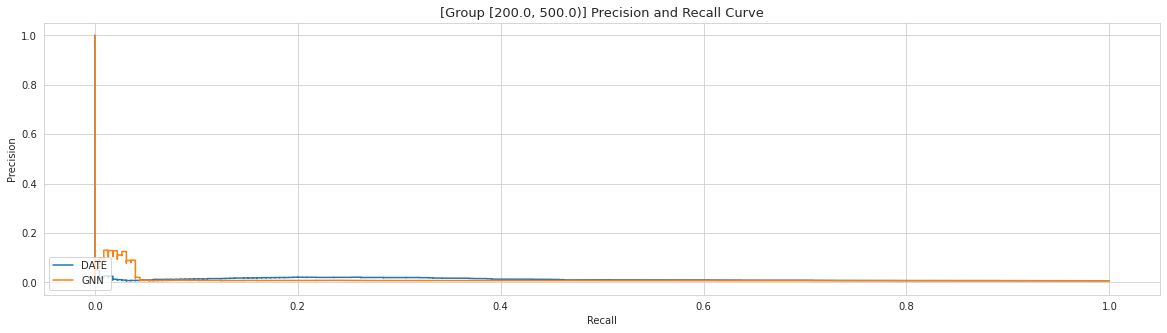

===============Evaluating subgroup:[500.0, inf)===============
GNN Results...
Checking top 1% suspicious transactions: 2040
Precision: 0.0029, Recall: 0.0160, Revenue: 0.0338
Checking top 2% suspicious transactions: 4079
Precision: 0.0022, Recall: 0.0239, Revenue: 0.0366
Checking top 5% suspicious transactions: 10196
Precision: 0.0021, Recall: 0.0559, Revenue: 0.1783
Checking top 10% suspicious transactions: 20392
Precision: 0.0023, Recall: 0.1223, Revenue: 0.1901
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 2039
Precision: 0.0025, Recall: 0.0133, Revenue: 0.0035
Checking top 2% suspicious transactions: 4079
Precision: 0.0025, Recall: 0.0266, Revenue: 0.0056
Checking top 5% suspicious transactions: 10196
Precision: 0.0027, Recall: 0.0745, Revenue: 0.1148
Checking top 10% suspicious transactions: 20392
Precision: 0.0023, Recall: 0.1223, Revenue: 0.1860


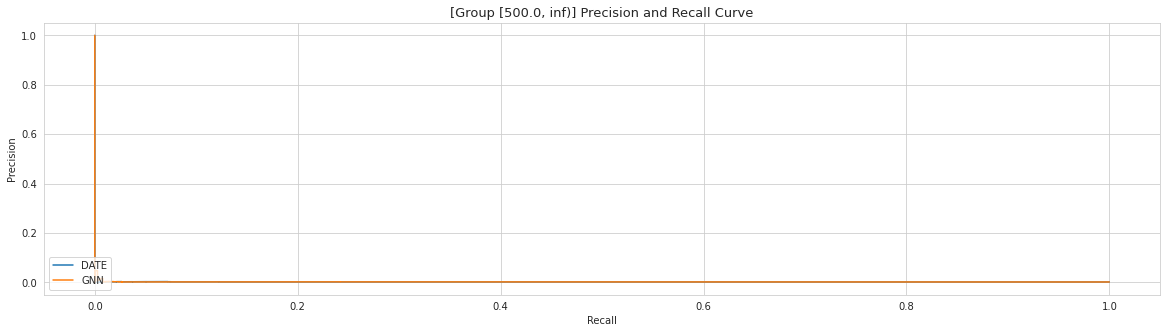

In [8]:
# calculate the frequency of importer of test transaction appearing in training set
cnter = Counter(gdata.train_user.numpy())
test_counts = [cnter.get(i,0) for i in gdata.test_user.numpy()]
count_Ser = pd.Series(test_counts)
train_counts = [cnter.get(i,0) for i in gdata.train_user.numpy()]
train_Ser = pd.Series(train_counts)

# plot training data for reference
bins = [0, 1,10,50,100,200,500,np.inf]
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1,2,1)
# cuteted_bin = pd.cut(train_Ser,bins, include_lowest=True, right=False).value_counts()
# cuteted_bin.plot(kind="bar",ax=ax1)
# plt.title("[Train] Frequency of importer appearing in the training set")
# plt.ylabel("# transaction")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)

# plot 
# ax2 = fig.add_subplot(1,2,2)
# cuteted_bin = pd.cut(count_Ser,bins, include_lowest=True, right=False).value_counts()
# cuteted_bin.plot(kind="bar",ax=ax2)
# plt.title("[Test] Frequency of importer appearing in the training set")
# plt.ylabel("# transaction")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# plt.show()

### illicit rate among different subgroup ###

# train
train_bins = pd.cut(train_Ser,bins, include_lowest=True, right=False)
train_label = pd.Series(data.train_cls_label)
train_summary = pd.concat([train_bins,train_label],axis=1)
train_summary.columns = ["bin","illicit"]

# test
test_bins = pd.cut(count_Ser,bins, include_lowest=True, right=False)
test_label = pd.Series(data.test_cls_label)
test_summary = pd.concat([test_bins,test_label],axis=1)
test_summary.columns = ["bin","illicit"]

#--------- plots for analysis-----------------
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1,2,1)
# plt.xticks(rotation=30)
# train_summary = train_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
# train_summary.plot(kind="bar",ax=ax1)
# plt.title("[Train] Illicit rate among different subgroup")
# plt.ylabel("illicit rate")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# ax2 = fig.add_subplot(1,2,2)
# test_summary = test_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
# test_summary.plot(kind="bar",ax=ax2)
# plt.title("[Test] Illicit rate among different subgroup")
# plt.ylabel("illicit rate")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# plt.show()

# ----------prediction analysis--------------
analysis = pd.DataFrame({"bins":test_bins.values, \
                             "gnn":GNN_prediction, "DATE":DATE_prediction, \
                             "cls_label":data.test_cls_label, "rev_label": data.test_reg_label})
for groupID, subgroup in analysis.groupby("bins"):
    print("="*15+"Evaluating subgroup:%s" % groupID + "="*15)
    # metrics
    print("GNN Results...")
    metrics(subgroup["gnn"],subgroup["cls_label"],subgroup["rev_label"],None)
    print("-"*40)
    print("DATE Results...")
    metrics(subgroup["DATE"],subgroup["cls_label"],subgroup["rev_label"],None)
    # plots
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,1,1)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["DATE"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "DATE",ax=ax)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["gnn"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "GNN",ax=ax)
    plt.title("[Group %s] Precision and Recall Curve" % groupID, fontsize=13)
    plt.show()

### HS code Analysis

===============Evaluating subgroup:[0.0, 1.0)===============
GNN Results...
Checking top 1% suspicious transactions: 268
Precision: 0.0448, Recall: 0.0263, Revenue: 0.0209
Checking top 2% suspicious transactions: 536
Precision: 0.0485, Recall: 0.0570, Revenue: 0.0486
Checking top 5% suspicious transactions: 1339
Precision: 0.0358, Recall: 0.1053, Revenue: 0.0976
Checking top 10% suspicious transactions: 2677
Precision: 0.0295, Recall: 0.1732, Revenue: 0.2101
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 268
Precision: 0.0373, Recall: 0.0219, Revenue: 0.0104
Checking top 2% suspicious transactions: 536
Precision: 0.0354, Recall: 0.0417, Revenue: 0.0288
Checking top 5% suspicious transactions: 1339
Precision: 0.0396, Recall: 0.1162, Revenue: 0.0964
Checking top 10% suspicious transactions: 2677
Precision: 0.0362, Recall: 0.2127, Revenue: 0.1828


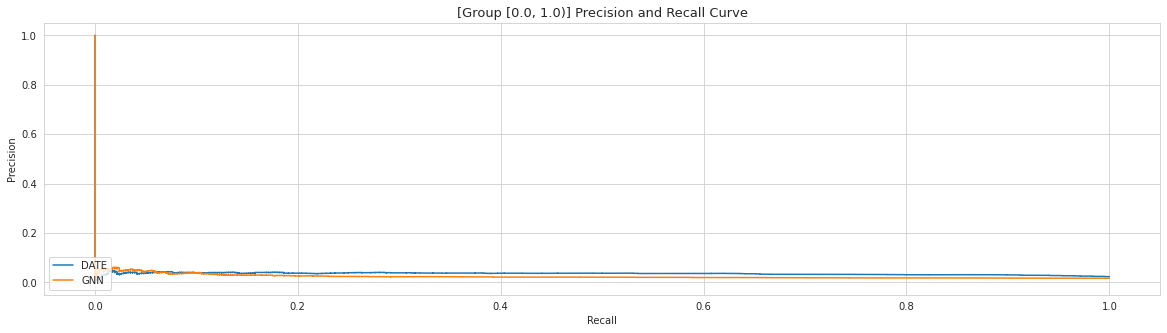

===============Evaluating subgroup:[1.0, 10.0)===============
GNN Results...
Checking top 1% suspicious transactions: 768
Precision: 0.0208, Recall: 0.0185, Revenue: 0.0344
Checking top 2% suspicious transactions: 1535
Precision: 0.0176, Recall: 0.0312, Revenue: 0.0518
Checking top 5% suspicious transactions: 3838
Precision: 0.0164, Recall: 0.0729, Revenue: 0.0886
Checking top 10% suspicious transactions: 7675
Precision: 0.0151, Recall: 0.1343, Revenue: 0.1435
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 768
Precision: 0.0156, Recall: 0.0139, Revenue: 0.0162
Checking top 2% suspicious transactions: 1535
Precision: 0.0228, Recall: 0.0405, Revenue: 0.0459
Checking top 5% suspicious transactions: 3838
Precision: 0.0253, Recall: 0.1123, Revenue: 0.1117
Checking top 10% suspicious transactions: 7675
Precision: 0.0266, Recall: 0.2361, Revenue: 0.2365


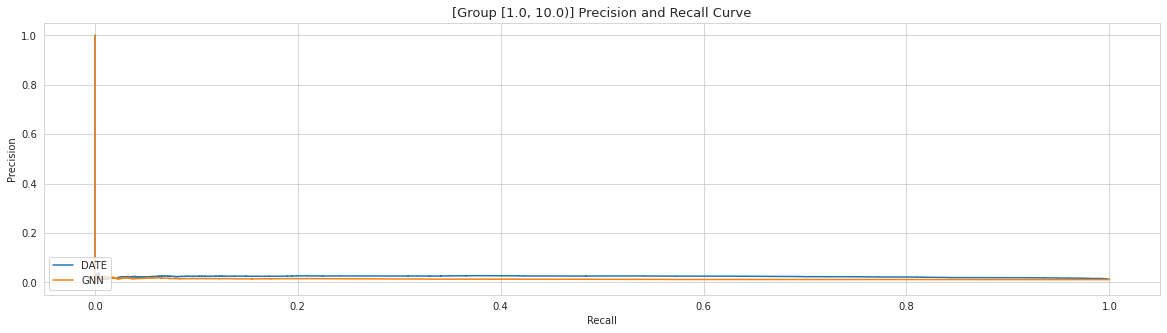

===============Evaluating subgroup:[10.0, 50.0)===============
GNN Results...
Checking top 1% suspicious transactions: 1645
Precision: 0.0219, Recall: 0.0233, Revenue: 0.0465
Checking top 2% suspicious transactions: 3289
Precision: 0.0210, Recall: 0.0446, Revenue: 0.0680
Checking top 5% suspicious transactions: 8221
Precision: 0.0176, Recall: 0.0937, Revenue: 0.1257
Checking top 10% suspicious transactions: 16442
Precision: 0.0147, Recall: 0.1558, Revenue: 0.1921
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 1645
Precision: 0.0517, Recall: 0.0549, Revenue: 0.0853
Checking top 2% suspicious transactions: 3288
Precision: 0.0383, Recall: 0.0814, Revenue: 0.1246
Checking top 5% suspicious transactions: 8221
Precision: 0.0283, Recall: 0.1506, Revenue: 0.2246
Checking top 10% suspicious transactions: 16442
Precision: 0.0250, Recall: 0.2657, Revenue: 0.3621


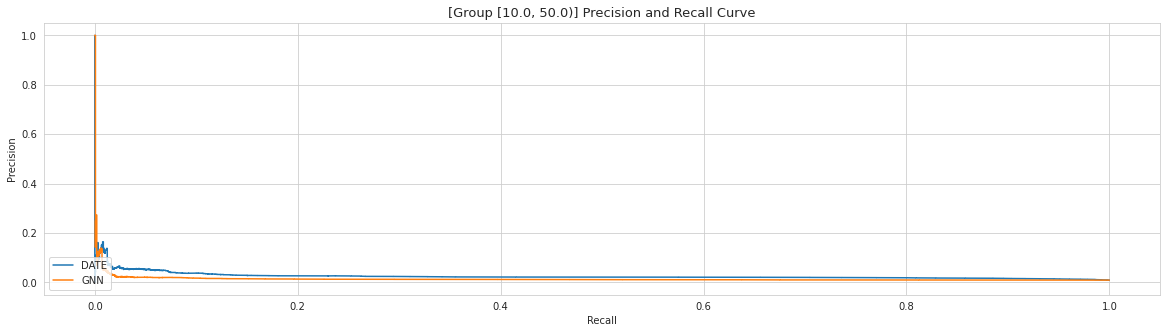

===============Evaluating subgroup:[50.0, 100.0)===============
GNN Results...
Checking top 1% suspicious transactions: 944
Precision: 0.0297, Recall: 0.0218, Revenue: 0.0511
Checking top 2% suspicious transactions: 1887
Precision: 0.0238, Recall: 0.0351, Revenue: 0.0850
Checking top 5% suspicious transactions: 4716
Precision: 0.0244, Recall: 0.0896, Revenue: 0.1649
Checking top 10% suspicious transactions: 9429
Precision: 0.0231, Recall: 0.1699, Revenue: 0.2565
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 944
Precision: 0.1017, Recall: 0.0748, Revenue: 0.1017
Checking top 2% suspicious transactions: 1887
Precision: 0.0694, Recall: 0.1021, Revenue: 0.1476
Checking top 5% suspicious transactions: 4716
Precision: 0.0511, Recall: 0.1878, Revenue: 0.2563
Checking top 10% suspicious transactions: 9431
Precision: 0.0412, Recall: 0.3032, Revenue: 0.4050


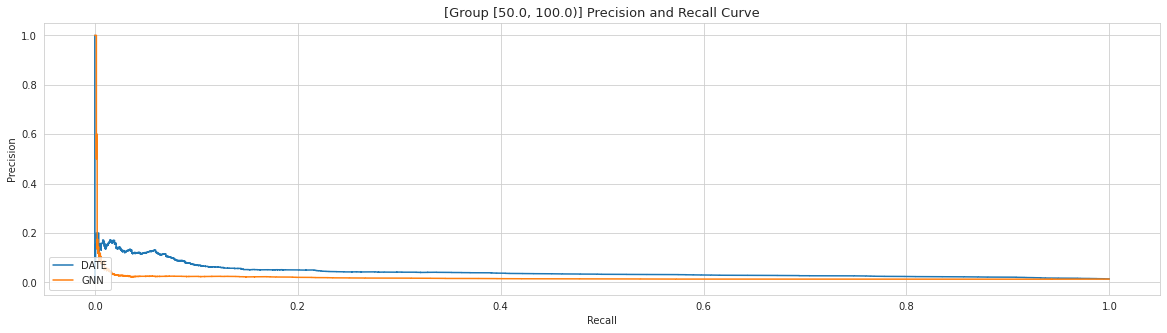

===============Evaluating subgroup:[100.0, 200.0)===============
GNN Results...
Checking top 1% suspicious transactions: 888
Precision: 0.0225, Recall: 0.0196, Revenue: 0.0485
Checking top 2% suspicious transactions: 1775
Precision: 0.0180, Recall: 0.0314, Revenue: 0.0645
Checking top 5% suspicious transactions: 4438
Precision: 0.0158, Recall: 0.0686, Revenue: 0.1161
Checking top 10% suspicious transactions: 8875
Precision: 0.0144, Recall: 0.1255, Revenue: 0.1767
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 888
Precision: 0.0338, Recall: 0.0294, Revenue: 0.0368
Checking top 2% suspicious transactions: 1775
Precision: 0.0321, Recall: 0.0559, Revenue: 0.0720
Checking top 5% suspicious transactions: 4438
Precision: 0.0349, Recall: 0.1520, Revenue: 0.2011
Checking top 10% suspicious transactions: 8875
Precision: 0.0320, Recall: 0.2784, Revenue: 0.3791


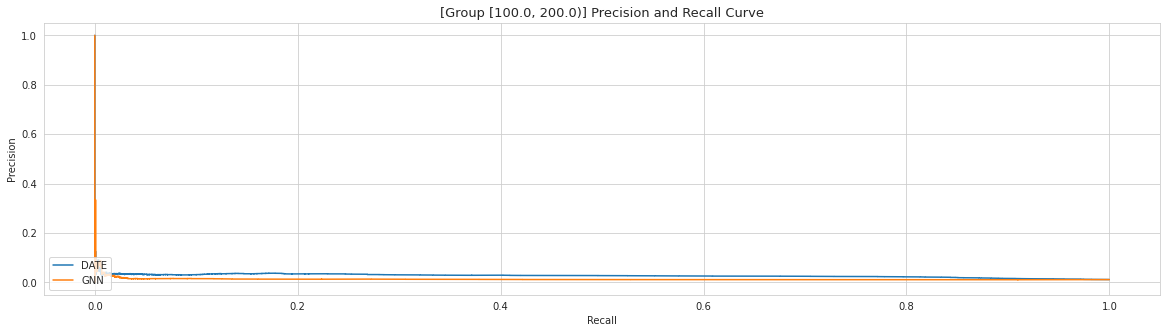

===============Evaluating subgroup:[200.0, 500.0)===============
GNN Results...
Checking top 1% suspicious transactions: 671
Precision: 0.0447, Recall: 0.0261, Revenue: 0.0584
Checking top 2% suspicious transactions: 1342
Precision: 0.0350, Recall: 0.0408, Revenue: 0.0808
Checking top 5% suspicious transactions: 3353
Precision: 0.0286, Recall: 0.0834, Revenue: 0.1378
Checking top 10% suspicious transactions: 6706
Precision: 0.0242, Recall: 0.1407, Revenue: 0.1849
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 670
Precision: 0.0552, Recall: 0.0321, Revenue: 0.0778
Checking top 2% suspicious transactions: 1342
Precision: 0.0574, Recall: 0.0669, Revenue: 0.1836
Checking top 5% suspicious transactions: 3353
Precision: 0.0495, Recall: 0.1442, Revenue: 0.3142
Checking top 10% suspicious transactions: 6705
Precision: 0.0437, Recall: 0.2546, Revenue: 0.4324


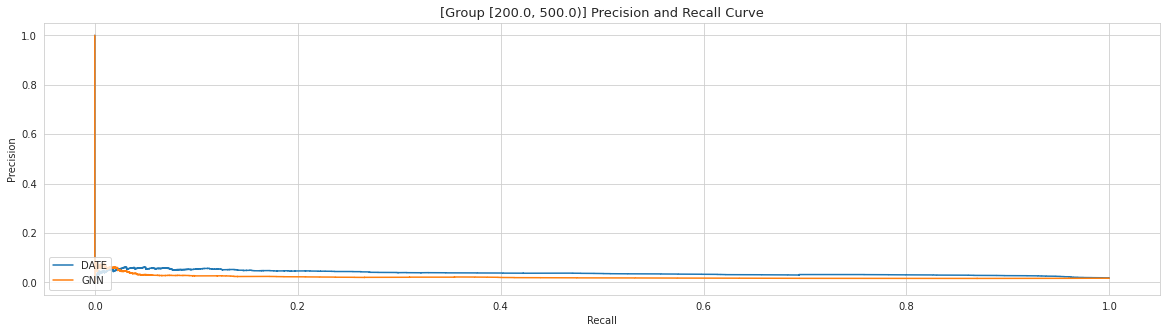

===============Evaluating subgroup:[500.0, inf)===============
GNN Results...
Checking top 1% suspicious transactions: 464
Precision: 0.0323, Recall: 0.0179, Revenue: 0.0242
Checking top 2% suspicious transactions: 926
Precision: 0.0302, Recall: 0.0333, Revenue: 0.0385
Checking top 5% suspicious transactions: 2316
Precision: 0.0259, Recall: 0.0714, Revenue: 0.1038
Checking top 10% suspicious transactions: 4631
Precision: 0.0194, Recall: 0.1071, Revenue: 0.1658
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 464
Precision: 0.0323, Recall: 0.0179, Revenue: 0.0208
Checking top 2% suspicious transactions: 927
Precision: 0.0378, Recall: 0.0417, Revenue: 0.0671
Checking top 5% suspicious transactions: 2316
Precision: 0.0436, Recall: 0.1202, Revenue: 0.1665
Checking top 10% suspicious transactions: 4631
Precision: 0.0425, Recall: 0.2345, Revenue: 0.3120


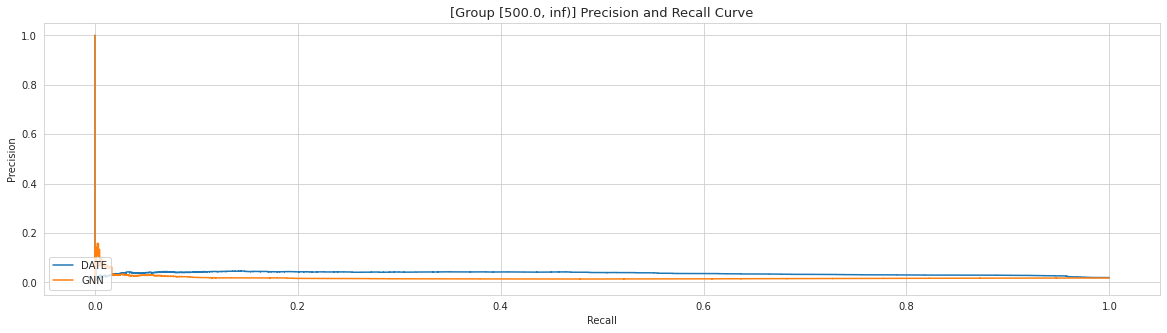

In [9]:
# calculate the frequency of importer of test transaction appearing in training set
cnter = Counter(gdata.train_item.numpy())
test_counts = [cnter.get(i,0) for i in gdata.test_item.numpy()]
count_Ser = pd.Series(test_counts)
train_counts = [cnter.get(i,0) for i in gdata.train_item.numpy()]
train_Ser = pd.Series(train_counts)

# plot training data for reference
bins = [0, 1,10,50,100,200,500,np.inf]
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1,2,1)
# cuteted_bin = pd.cut(train_Ser,bins, include_lowest=True, right=False).value_counts()
# cuteted_bin.plot(kind="bar",ax=ax1)
# plt.title("[Train] Frequency of HSCode appearing in the training set")
# plt.ylabel("# transaction")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)

# # plot 
# ax2 = fig.add_subplot(1,2,2)
# cuteted_bin = pd.cut(count_Ser,bins, include_lowest=True, right=False).value_counts()
# cuteted_bin.plot(kind="bar",ax=ax2)
# plt.title("[Test] Frequency of HSCode appearing in the training set")
# plt.ylabel("# transaction")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# plt.show()

### illicit rate among different subgroup ###

# train
train_bins = pd.cut(train_Ser,bins, include_lowest=True, right=False)
train_label = pd.Series(data.train_cls_label)
train_summary = pd.concat([train_bins,train_label],axis=1)
train_summary.columns = ["bin","illicit"]

# test
test_bins = pd.cut(count_Ser,bins, include_lowest=True, right=False)
test_label = pd.Series(data.test_cls_label)
test_summary = pd.concat([test_bins,test_label],axis=1)
test_summary.columns = ["bin","illicit"]

# ----------plots for analysis--------------
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1,2,1)
# plt.xticks(rotation=30)
# train_summary = train_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
# train_summary.plot(kind="bar",ax=ax1)
# plt.title("[Train] Illicit rate among different subgroup")
# plt.ylabel("illicit rate")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# ax2 = fig.add_subplot(1,2,2)
# test_summary = test_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
# test_summary.plot(kind="bar",ax=ax2)
# plt.title("[Test] Illicit rate among different subgroup")
# plt.ylabel("illicit rate")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# plt.show()

# ----------prediction analysis--------------
analysis = pd.DataFrame({"bins":test_bins.values, \
                             "gnn":GNN_prediction, "DATE":DATE_prediction, \
                             "cls_label":data.test_cls_label, "rev_label": data.test_reg_label})
for groupID, subgroup in analysis.groupby("bins"):
    print("="*15+"Evaluating subgroup:%s" % groupID + "="*15)
    # metrics
    print("GNN Results...")
    metrics(subgroup["gnn"],subgroup["cls_label"],subgroup["rev_label"],None)
    print("-"*40)
    print("DATE Results...")
    metrics(subgroup["DATE"],subgroup["cls_label"],subgroup["rev_label"],None)
    # plots
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,1,1)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["DATE"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "DATE",ax=ax)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["gnn"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "GNN",ax=ax)
    plt.title("[Group %s] Precision and Recall Curve" % groupID, fontsize=13)
    plt.show()